# Gathering Sentinel-2 data for RGB bands (actual images)
This notebook describes how to download data frrom Sentinel-2 satellite from Sentinel Hub API. It follows the tutorial from 
https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html. Sentinel-2 has 13 various spectral bands. Here we get data for only three of them (Red, Green, and Blue) per geo-location (i.e., we collect actual images)

Before working with this notebook, get first familiar with Download_Sentinel_2_Pixels.ipynb and comments therein. The code is basically identical. The only difference is that we gather images instead of pixels and consider only 3 spectral bands.

In [1]:
from sentinelhub import SHConfig
config = SHConfig()
#config

#account mi4people (expired)
#config.instance_id = '0c5d4483-7a81-48da-9be5-b74d3ca7c996'
#config.sh_client_id = '69692447-b415-461d-a73d-9ad4841f013e'
#config.sh_client_secret = '5f?[xZBfbcB~Vy;JIboqWq9*rE}TnT4Pju5,eLIF'
#config.save()

#acount gmx (expired)
# config.instance_id = '4df1188c-af0b-4f5d-9803-597915205fb8'
# config.sh_client_id = 'fe7ca65a-8de6-406a-8407-6a747478d635'
# config.sh_client_secret = 'xQkVu:za1Y156N/E6E3^j-KBE5E)sZ,Zzn6obAEs'
# config.save()




c:\Users\Philip\anaconda3\envs\mi4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import savez_compressed

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

from joblib import Parallel, delayed

In [4]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [6]:
resolution = 20 # resolution is 20 meters

In [7]:
olc_ids = pd.read_csv('OLC_ID_Mapping.csv')
olc_ids.shape

(15479, 3)

In [8]:
# Note: for olc_id = 5G55HPG4+MM7, I got error. Every other image was downloaded without any problem. I don't know what
# is wrong with 5G55HPG4+MM7, but we should exclude in further analysis (it is currently in training data set).

In [9]:
def download_rgb_imgs(index, row):
    # +/-0.03 from the center of olc_id coordinates to define shape of the image.
    coord = [row['lon'] - 0.03, row['lat'] - 0.03, row['lon'] + 0.03, row['lat'] + 0.03]

    bbox = BBox(bbox=coord, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)

    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                # we take a picture with less possible clouds in the last two months
                time_interval=('2021-10-16', '2021-12-16'),
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        config=config
    )

    true_color_imgs = request_true_color.get_data()

    image_raw = true_color_imgs[0] / 255  # get image and normalize all RGB channels to 0-1

    # crop to only 224x224 pixels image in the centre. 224x224 is the native resolution of ResNet50 - the network we use for
    # transfer learning. With reolution of 20m, we cover area of ca. 4.5km x 4.5 km
    xStart = math.floor((image_raw.shape[0] - 224) / 2)
    yStart = math.floor((image_raw.shape[1] - 224) / 2)
    xEnd = xStart + 224
    yEnd = yStart + 224
    image = image_raw[xStart:xEnd, yStart:yEnd, 0:3]

    savez_compressed("images/" + row['olc_id'] + ".npz", image)  # save the image as compressed numpy array

    # print(index)


In [10]:
# Parallel execution of downloads
Parallel(n_jobs=8)(delayed(download_rgb_imgs)(index, row) for index, row in olc_ids.iterrows())
    

KeyboardInterrupt: 

In [ ]:
# test whether we can interpret mpz files as images
a = np.load("images/5GP843MX+2CM.npz")["arr_0"]

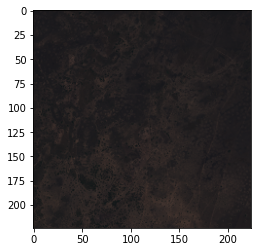

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(a)